In [118]:
import pandas as pd
import numpy as np
from keras.utils.np_utils import to_categorical

#Загрузим данные
df_train = pd.read_csv('adult.data', sep =', ')
df_valid = pd.read_csv('adult.test', sep =', ')
print('------------- data loaded -----------')
print(df_valid.dtypes)
print('----------')
print(df_train.dtypes)

D:\soft\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
D:\soft\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


------------- data loaded -----------
age     int64
wcl    object
wgt     int64
edu    object
edn     int64
mts    object
ocp    object
rls    object
rac    object
sex    object
cpg     int64
cpl     int64
hpw     int64
ctr    object
inc    object
dtype: object
----------
age     int64
wcl    object
wgt     int64
edu    object
edn     int64
mts    object
ocp    object
rls    object
rac    object
sex    object
cpg     int64
cpl     int64
hpw     int64
ctr    object
inc    object
dtype: object


In [119]:
from sklearn.preprocessing import LabelBinarizer

def replace_spaces(arr) :
    for i in range(0, len(arr)):
        el = arr[i]
        if (isinstance(el, str)):
            arr[i] = el.replace(' ', '').replace('.', '').upper()
    return arr

def tranform_dtype(df):
    columns = df.select_dtypes(['object']).columns
    for i in columns:
        df[i] = replace_spaces(df[i].to_numpy())
        df[i] = df[i].astype('category')
    df[columns] = df[columns].apply(lambda x: x.cat.codes)

def tranform_dtype1(df):
    columns = df.select_dtypes(['object']).columns
    for i in columns:
        df[i] = replace_spaces(df[i].to_numpy())
        if len(df.groupby([i]).size()) > 2:
         df = pd.get_dummies(df, prefix=[i], columns=[i])
    return pd.get_dummies(df, drop_first=True)

print('------------Prepare DF binarization -----------------------')
df_valid = tranform_dtype1(df_valid)
df_valid['ctr_HOLAND-NETHERLANDS'] = np.zeros(len(df_valid['ctr_LAOS']))
df_train = tranform_dtype1(df_train)
df_valid = df_valid[df_train.columns]
# print('------------Prepare DF categorization -----------------------')
# tranform_dtype(df_valid)
# tranform_dtype(df_train)
#
# print(df_valid)
# print(df_train)

------------Prepare DF binarization -----------------------


In [120]:
data_valid = df_valid.to_numpy()
data_train = df_train.to_numpy()

train_label = to_categorical(data_train[:, -1])
train_sample = data_train[:, :-1]
train_sample = train_sample.reshape(len(train_sample), train_sample.shape[1], 1)

valid_label = to_categorical(data_valid[:, -1])
valid_sample = data_valid[:,:-1]
valid_sample = valid_sample.reshape(len(valid_sample), valid_sample.shape[1], 1)
print('Train labels shape = ', train_label.shape)
print('Train samples shape = ', train_sample.shape)
print('Validation labels shape = ', valid_label.shape)
print('Validation samples shape = ', valid_sample.shape)


Train labels shape =  (32561, 2)
Train samples shape =  (32561, 107, 1)
Validation labels shape =  (16281, 2)
Validation samples shape =  (16281, 107, 1)


In [124]:
from tensorflow.keras import models
from tensorflow.keras import layers

print('------- Prepare Model -----------------')
actv = 'sigmoid'
model = models.Sequential()
model.add(layers.Conv1D(14,6,activation=actv, input_shape=(train_sample.shape[1], 1)))
model.add(layers.MaxPool1D(pool_size=3, strides=(2), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(32,3,activation=actv))
model.add(layers.MaxPool1D(pool_size=3, strides=(2), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.05))
model.add(layers.Conv1D(16,2,activation=actv))
model.add(layers.MaxPool1D(pool_size=3, strides=(2), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation=actv))
model.add(layers.Dense(64, activation=actv))
model.add(layers.Dense(32, activation=actv))
model.add(layers.Dense(16,  activation=actv))
model.add(layers.Dense(8,  activation=actv))
model.add(layers.Dense(2,  activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(x=train_sample,
                    y=train_label,
                    epochs=15,
                    batch_size=128,
                    validation_data = (valid_sample, valid_label)
                    )

------- Prepare Model -----------------
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 102, 14)           98        
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 51, 14)            0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 51, 14)            56        
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 49, 32)            1376      
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 25, 32)            0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 25, 32)            128       
_________________________________________________________________
dropout_2 (Dr

------- Plot losses -----------------


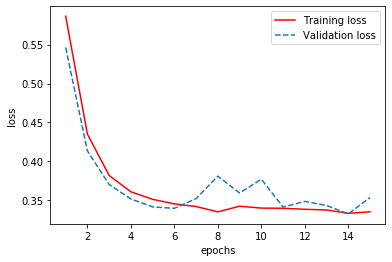

In [125]:
import matplotlib.pyplot as plt
print('------- Plot losses -----------------')
hist_dcit = history.history
loss = hist_dcit['loss']
val_loss = hist_dcit['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b',color='r', label = 'Training loss')
plt.plot(epochs, val_loss, '--', label = 'Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

------- Plot acc -----------------


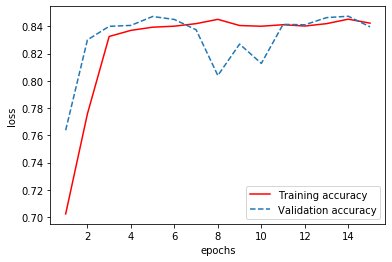

In [126]:
print('------- Plot acc -----------------')
acc = hist_dcit['accuracy']
val_acc = hist_dcit['val_accuracy']
plt.plot(epochs, acc, 'b',color='r',label = 'Training accuracy')
plt.plot(epochs, val_acc, '--', label = 'Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()
